In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## train_data

### まずは欠損値等の確認

In [2]:
sale_train = pd.read_csv('../data/sales_train_v2.csv')

In [3]:
display(sale_train.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
# データの基本情報を確認

print("----------Top-5- Record----------")
print(sale_train.head(5))
print("-----------Information-----------")
print(sale_train.info())
print("-----------Data Types-----------")
print(sale_train.dtypes)
print("----------Missing value-----------")
print(sale_train.isnull().sum())
print("----------Null value-----------")
print(sale_train.isna().sum())
print("----------Shape of Data----------")
print(sale_train.shape)

----------Top-5- Record----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
-----------Data Types-----------
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        flo

In [5]:
# データに重複がないかチェック
print('Number of duplicates:', len(sale_train[sale_train.duplicated()]))

Number of duplicates: 6


重複は6件あるらしい（集計ミスではない可能性もあるので無視）

In [6]:
# データのバイト数を落としてメモリを節約する

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

sale_train = downcast_dtypes(sale_train)
print(sale_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int16
shop_id           int16
item_id           int16
item_price        float32
item_cnt_day      float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB
None


## Item_id

### 商品全体の売り上げの傾向を見る

In [7]:
# データをピボットテーブルで集計　※https://note.nkmk.me/python-pandas-pivot-table/
# 列：item_id、行：date_block_num(月)、値：item_cnt_day(売れた商品の数)

sales_by_item_id = sale_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'

display(sales_by_item_id.head())

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\raiji\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


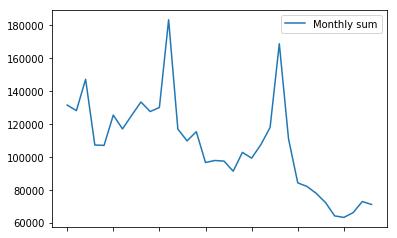

In [8]:
# 月ごとに売れた商品数の合計数の推移

sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

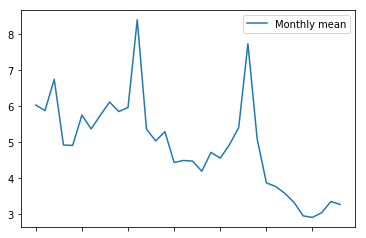

In [9]:
# 月ごとに売れた商品数の平均値の推移

sales_by_item_id.mean()[1:].plot(legend=True, label="Monthly mean")

In [10]:
# 補足（kernelにはない集計）
# 売り上げと商品数の確認

print("月ごとの総売り上げ商品数の平均値：", sales_by_item_id.sum()[1:].mean())
print("商品数：", len(sales_by_item_id["item_id"]))
print("月ごとの1商品当たり平均売り上げ数の平均値：", sales_by_item_id.mean()[1:].mean())

月ごとの総売り上げ商品数の平均値： 107300.17647058824
商品数： 21807
月ごとの1商品当たり平均売り上げ数の平均値： 4.92044648372487


総売り上げ数に対して商品数が多すぎる<br>　→　全く売れていないブームの去った商品(outdated_items)があるのではないか？

### 商品ごとの売り上げの傾向を見る

In [11]:
# 27月目以降で全く売れていない商品を抽出し、項目数をカウントする

outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))

Outdated items: 12391


In [12]:
# test dataでこの全く売れていない商品は何個含まれている？

test = pd.read_csv('../data/test.csv')
print('Outdated items in test set:', len(test[test['item_id'].isin(outdated_items['item_id'])]))

Outdated items in test set: 6888


後半7か月で全く売れていない12391商品のうち6888商品がtestでの予測対象

#### ※補足情報
train：2013/1～2015/10の売り上げ<br>
test ：2015/11の売り上げ(を予測する)

### 価格＆売り上げ数での外れ値商品を探す

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


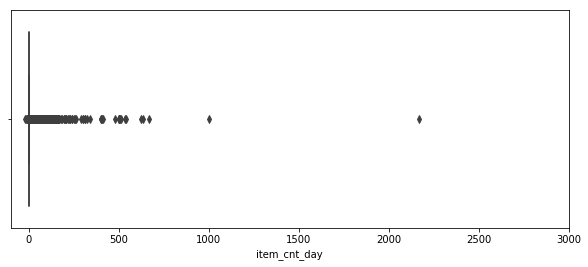

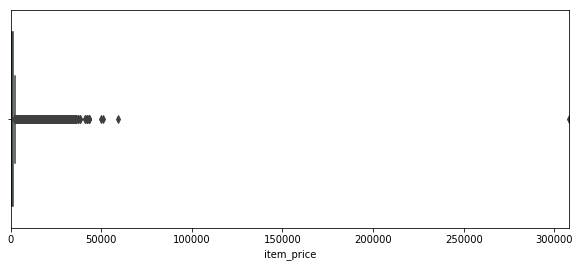

In [13]:
# 一日の売上個数をグラフ化
# 一日の売上個数が500個を1日でも超えたことがある商品を抽出

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sale_train['item_cnt_day'])
print('Sale volume outliers:',sale_train['item_id'][sale_train['item_cnt_day']>500].unique())


# 商品の価格をグラフ化
# 商品の価格が50000ルーブル(約83000円)を超える商品を抽出

plt.figure(figsize=(10,4))
plt.xlim(sale_train['item_price'].min(), sale_train['item_price'].max())
sns.boxplot(x=sale_train['item_price'])
print('Item price outliers:',sale_train['item_id'][sale_train['item_price']>50000].unique())

#### item_idについてのまとめ
このデータから読み取れること
1. Lags(遅延？)
2. Release date(発売日)
3. Last month sale(最終月の売り上げ)
4. Days on sale(一日の売り上げ)
5. Neighbors(類似度)　idが近いと商品が似ている

↑　idにkey以外の意味合いを持たせて予測するのはナンセンスなのでは？？？

## shop_id

In [14]:
# データをピボットテーブルで集計
# 列：data_block_num(月), 行：shop_id, 値：item_cnt_day(一日に売れた商品数)
sales_by_shop_id = sale_train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)  # 列名から文字列を削除
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

display(sales_by_shop_id.head())

# iヶ月目にオープンした店
for i in range(6,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

# iヶ月目に閉店した店
for i in range(6,28):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

,shop_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,5578,6127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2947,3364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1146,488,753,583,553,832,807,875,945,...,987,907,762,859,843,804,785,942,822,727
3,3,767,798,959,647,710,784,721,890,1026,...,977,738,741,740,731,672,535,666,745,613
4,4,2114,2025,2060,285,1211,1464,1378,1713,1536,...,1188,980,978,899,893,793,842,947,732,831


Not exists in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exists in month 9 [11 20 33 34 36 39 40 48 49]
Not exists in month 10 [11 20 33 34 36 39 40 48 49]
Not exists in month 11 [11 20 33 34 36 39 40 48]
Not exists in month 12 [11 20 33 34 36 39 40 48]
Not exists in month 13 [11 20 33 34 36 39 40 48]
Not exists in month 14 [11 20 33 34 36 48]
Not exists in month 15 [11 20 33 34 36]
Not exists in month 16 [11 20 33 34 36]
Not exists in month 17 [11 20 33 34 36]
Not exists in month 18 [11 20 33 36]
Not exists in month 19 [11 20 36]
Not exists in month 20 [11 20 36]
Not exists in month 21 [11 36]
Not exists in month 22 [11 36]
Not exists in month 23 [11 36]
Not exists in month 24 [11 36]
Not exists in month 25 [36]
Not exists in month 26 [36]
Not exists in month 27 [36]
Not exists in month 28 [36]
Not exists in month 29 [36]
Not exists in month 30 [36]
Not exists in month 31 [36]


In [15]:
# 空いている店の商品数はすべて5100

print('Recently opened shop items:', len(test[test['shop_id']==31]))

Recently opened shop items: 5100


#### shop_idについてのまとめ

このデータから読み取れるもの
1. Lags (shop_id/shp_cnt_mth)
2. Opening month (開店月　開店セールでよく売れる傾向あり)
3. Closed Month (閉店月　だんだん在庫がなくなっていく)


## Price

Priceについて読み取れるもの
1. Price category (価格帯　値段が安いほどよく売れる傾向)
2. Discount and Discount duration（値引きとその期間）
3. Price lag (価格差？)
4. Price correction (rubl→米ドルに変換？)
5. Shop Revenue（店の収益）

## Dates

Datesについて読み取れるもの
1. Weekends and holidays sales (週末や休日の売り上げ)
2. Number of days in the month (月による日の数)
3. Month number (月　季節もの商品の予測に使える)

## Shop info

In [16]:
shops = pd.read_csv('../data/shops.csv')
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


よく見るといくつかの店でほぼ同じ名前なのに異なるidを持った店がいくつかある。<br>
気にしなくてもいいかもしれないが、この人は以下のidをマージしているらしい（コードはなし）
- 11 => 10
- 1 => 58
- 0 => 57
- 40 => 39


In [17]:
# shopsについての情報を整理している

shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


In [27]:
# shop_cityの合計数
len(set(shops["shop_city"]))

31

shopについて読み取れるもの
1. Shop City
2. Shop Type

## Item info

In [18]:
items = pd.read_csv('../data/items.csv')
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [29]:
len(set(items["item_category_id"]))

84

In [19]:
# item_nameについていじいじ

# []または()でくくられているものを取り出す
# Ugly code to show the idea
from collections import Counter
from operator import itemgetter
items['name_1'], items['name_2'] = items['item_name'].str.split('[', 1).str
items['name_1'], items['name_3'] = items['item_name'].str.split('(', 1).str

items['name_2'] = items['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items['name_3'] = items['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items = items.fillna('0')


# nome_2とname_3の頻出単語(200超え)を抽出してresultに保存

result_1 = Counter(' '.join(items['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature'])

print('Most common aditional features:', result)

Most common aditional features:            feature  count
130   документация    284
131     английская    340
132        русские    399
133       субтитры    400
134            360    465
135          jewel    552
136           xbox    589
137            ps3    611
138        русская   1428
139       цифровая   1995
140             pc   2585
141         версия   3427
1981           box    246
1983            3d    409
1985           dvd    503
1986      digipack    541
1988          фирм    757
1991           mp3    854
1992            cd    871
1993        регион   1849
1994            bd   2320


In [20]:
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,***КОРОБКА (СТЕКЛО) D,4,40,***КОРОБКА,0,стекло d


In [21]:
print('Unique item names:', len(items['item_name'].unique()))

Unique item names: 22170


In [22]:
# 記号とかを除いてitem_nameを定義しなおす

import re
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items['item_name'] = items['item_name'].apply(lambda x: name_correction(x))
items.head()

,item_name,item_id,item_category_id,name_1,name_2,name_3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d


In [23]:
print('Unique item names after correction:', len(items['item_name'].unique()))

Unique item names after correction: 18121


記号を減らすと22170から18121種類に減らすことができた

itemについて読み取れるもの
1. Item name(アイテムの名前)
2. Encoded aditional feature(加工した新しい変数)

## Category info

In [24]:
categories = pd.read_csv('../data/item_categories.csv')
categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


item_category_nameの構造は「セクション名-サブセクション名」で成り立っている<br>
これをさらに分解して、「セクション名/サブセクション名(カテゴリー名)/カテゴリー1/カテゴリー2」とも読み取れる。<br>
ex) 「Аксессуары - PS2」→「Аксессуары / PS2 / PS/ 2」

Categoryについて読み取れるもの
1. Section(セクション名)
2. Main Category name(カテゴリー名)
3. Main SubCategory name（1つ目のサブカテゴリー名）
4. Secondary SubCategory name（2つ目のサブカテゴリー名）

## Test Set

ここについての分析が大事！<br>
itemsは3つのグループに分けられる
1. Item/shop pairs that are in train（item,shopともにtrainデータにあるもの）
2. Items without any data（itemがtrainデータにないもの）
3. Items that are in train（itemはtrainにあるが対応するshopでは売っていなかったもの）

In [25]:
test = pd.read_csv('../data/test.csv')
good_sales = test.merge(sale_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sale_train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))

1. Number of good pairs: 111404
2. No Data Items: 15246
3. Only Item_id Info: 87550


この3グループごとにそれぞれ異なるアプローチ方法で予測する<br>
ex) No Data Itemsは分類タスクになるはず